## Exercise

### 1. Load Data
Loading up data of `torchvision.datasets.CIFAR10` (Canadian Institute For Advanced Research) Datasets which contains *60,000 32x32* color images in *10* different classes.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F   # Convert to PIL Image using torchvision.transforms.functional

print(torch.__version__)
print(torchvision.__version__)

# Setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
0.16.0+cu121
cpu


In [2]:
train_data = datasets.CIFAR10(root = "data",
                              train = True,
                              download = True,
                              transform = torchvision.transforms.ToTensor(),
                              target_transform = None)

test_data = datasets.CIFAR10(root = "data",
                             train = False,
                             download = True,
                             transform = torchvision.transforms.ToTensor(),
                             target_transform = None)

100%|██████████| 170498071/170498071 [00:02<00:00, 74885336.52it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
# Sample image
image, label = train_data[0]
image.shape, label

(torch.Size([3, 32, 32]), 6)

### 2. Mapping dictionary index to `class_labels`

In [5]:
class_name = train_data.classes
class_name, len(class_name)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
# Input and Ouput Shapes
image.shape, class_name[label], label

(torch.Size([3, 32, 32]), 'frog', 6)

From the shape of sample image of frog, it seems the image contains

`[color_channels=3, height=32, width=32]`

### 3. Visualizing the image

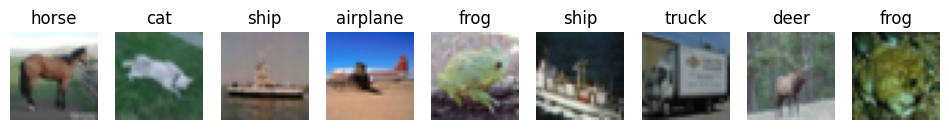

In [8]:
fig = plt.figure(figsize = (12, 5))
rows, cols = 1, 9

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(F.to_pil_image(image))
  plt.title(class_name[label])
  plt.axis(False);

### 4. Turn CIFAR10 train and test datasets into Dataloaders

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(1563, 313)

### 5. Build Model class

In [10]:
class CIFAR10Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(CIFAR10Model, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(hidden_units)  # Batch normalization for stabilization
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hidden_units)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(2 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(output_shape)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 4 * output_shape, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x


In [11]:
model = CIFAR10Model(3, 10, len(class_name)).to(device)
model, next(model.parameters()).device

(CIFAR10Model(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(40, 10, kernel_size=(3, 3), stride=(1, 1), padding=

### 6. Train and Test CIFAR10 Dataloaders

In [12]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.3 MB/s eta 0:00:00


In [13]:
# Import Accuracy
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = "multiclass",
                                 num_classes = len(class_name)).to(device)

In [14]:
# Setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [19]:
# Train and Test function
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += torchmetrics_accuracy(y,
                                       y_pred.argmax(dim = 1)) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f'Train loss: {train_loss:.4f} ---- Train acc: {train_acc:.2f}%')

def test_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += torchmetrics_accuracy(y,
                                        test_pred.argmax(dim = 1)) * 100

  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  print(f'Test loss: {test_loss:.4f} ---- Test acc: {test_acc:.2f}%')

In [20]:
torch.manual_seed(42)

from tqdm.auto import tqdm

epochs = 10
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_step(model, train_dataloader, loss_fn, optimizer,
             torchmetrics_accuracy, device)
  test_step(model, test_dataloader, loss_fn, optimizer,
             torchmetrics_accuracy, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.2935 ---- Train acc: 53.53%


UnboundLocalError: local variable 'train_acc' referenced before assignment